# Input:32 Output:32

In [14]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)



import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [5]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.2*4000=800

# spatial slicing dimensions
os = 32 # output slice size
ts = os # total input slice size 32
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 128 # number of slices in one profile 



In [6]:
print("train_size:",train_size)
print("test_size:",test_size)

train_size: 3200
test_size: 800


In [7]:
# spatial slicing the profiles

image=np.zeros((l2r*num,ts,nchan)) 
label=np.zeros((l2r*num,os)) 

for i in range(num):
    for a in range(l2r):
#cut each profile into 128 slices. 
#label: tau channel 
#1profile ..2profile...3 profile

        img= data[i, a*os:a*os+ts, 0:nchan] #input: 32 pixels for one slice, 3 channels 
        lb = data[i, a*os:a*os+os, nchan] #32 pixels for label,the tau channel is the label
        image[i*l2r+a]=img
        label[i*l2r+a]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) 


whole dataset features size:  (512000, 32, 3) whole dataset label size:  (512000, 32)


In [9]:
predictions = np.empty((test_size,os)) 
predictions.shape

(800, 32)

In [10]:

model_m = models.Sequential()
#model_m.add(layers.Embedding(input_dim=24,output_dim=72,input_shape=(ts,nchan)))
model_m.add(layers.LSTM(units=50, activation='tanh',return_sequences = True,input_shape=(ts,nchan))) #kernel size 6, 100 filters for each 3 channel
model_m.add(layers.LSTM(units=60, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
model_m.add(layers.LSTM(units=80, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
model_m.add(layers.LSTM(units=100, activation='tanh', return_sequences = True)) 

model_m.add(layers.Flatten())
model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

model_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 50)            10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 60)            26640     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 100)           72400     
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                102432    
Total params: 257,392
Trainable params: 257,392
Non-trainable params: 0
__________________________________________________

In [11]:
keras.utils.plot_model(model_m, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
# LSTM ------------------------------------------------------------------------------------------

def eval_model(train_image, test_image, train_label, test_label):

    model_m = models.Sequential()
    #model_m.add(layers.Embedding(input_dim=24,output_dim=72,input_shape=(ts,nchan)))
    model_m.add(layers.LSTM(units=50, activation='tanh',return_sequences = True,input_shape=(ts,nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.LSTM(units=60, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.LSTM(units=80, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.LSTM(units=100, activation='tanh', return_sequences = True)) 

    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

    model_m.summary()

    type2=tf.keras.metrics.RootMeanSquaredError() #RMSE
    ltype = 'mean_squared_error'
    bsize = 1024
    eps = 2000

    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ------------------------------------------------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)

    mse = results[1]
    rmse = results[2]  
    
    return model_m,rmse,mse,history,predictions

In [25]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(image))
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),ts,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts,3))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [102400 102401 102402 ... 511997 511998 511999] TEST: [     0      1      2 ... 102397 102398 102399]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [102400 102401 102402 ... 204797 204798 204799]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [204800 204801 204802 ... 307197 307198 307199]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [307200 307201 307202 ... 409597 409598 409599]
TRAIN: [     0      1      2 ... 409597 409598 409599] TEST: [409600 409601 409602 ... 511997 511998 511999]


In [26]:
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model_m,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 32, 50)            10800     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32, 60)            26640     
_________________________________________________________________
lstm_18 (LSTM)               (None, 32, 80)            45120     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32, 100)           72400     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                102432    
Total params: 257,392
Trainable params: 257,392
Non-trainable params: 0
________________________________________________

350/350 [==============================] - 7s 21ms/step - loss: 9.8260 - mean_squared_error: 9.8260 - root_mean_squared_error: 3.1311 - val_loss: 10.2469 - val_mean_squared_error: 10.2469 - val_root_mean_squared_error: 3.2011
Epoch 31/2000
350/350 [==============================] - 7s 21ms/step - loss: 11.3328 - mean_squared_error: 11.3328 - root_mean_squared_error: 3.3656 - val_loss: 9.1661 - val_mean_squared_error: 9.1661 - val_root_mean_squared_error: 3.0275
Epoch 32/2000
350/350 [==============================] - 7s 21ms/step - loss: 10.0969 - mean_squared_error: 10.0969 - root_mean_squared_error: 3.1765 - val_loss: 8.2489 - val_mean_squared_error: 8.2489 - val_root_mean_squared_error: 2.8721
Epoch 33/2000
350/350 [==============================] - 7s 21ms/step - loss: 9.1490 - mean_squared_error: 9.1490 - root_mean_squared_error: 3.0245 - val_loss: 8.0552 - val_mean_squared_error: 8.0552 - val_root_mean_squared_error: 2.8382
Epoch 34/2000
350/350 [==============================] -

350/350 [==============================] - 7s 21ms/step - loss: 5.1996 - mean_squared_error: 5.1996 - root_mean_squared_error: 2.2787 - val_loss: 5.6252 - val_mean_squared_error: 5.6252 - val_root_mean_squared_error: 2.3717
Epoch 65/2000
350/350 [==============================] - 7s 21ms/step - loss: 4.8516 - mean_squared_error: 4.8516 - root_mean_squared_error: 2.2023 - val_loss: 5.6063 - val_mean_squared_error: 5.6063 - val_root_mean_squared_error: 2.3678
Epoch 66/2000
350/350 [==============================] - 7s 21ms/step - loss: 4.6261 - mean_squared_error: 4.6261 - root_mean_squared_error: 2.1502 - val_loss: 4.8026 - val_mean_squared_error: 4.8026 - val_root_mean_squared_error: 2.1915
Epoch 67/2000
350/350 [==============================] - 7s 21ms/step - loss: 4.2810 - mean_squared_error: 4.2810 - root_mean_squared_error: 2.0686 - val_loss: 4.8743 - val_mean_squared_error: 4.8743 - val_root_mean_squared_error: 2.2078
Epoch 68/2000
350/350 [==============================] - 7s 21

350/350 [==============================] - 7s 21ms/step - loss: 1.9477 - mean_squared_error: 1.9477 - root_mean_squared_error: 1.3954 - val_loss: 3.1223 - val_mean_squared_error: 3.1223 - val_root_mean_squared_error: 1.7670
Epoch 99/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.9777 - mean_squared_error: 1.9777 - root_mean_squared_error: 1.4058 - val_loss: 2.8299 - val_mean_squared_error: 2.8299 - val_root_mean_squared_error: 1.6822
Epoch 100/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.8258 - mean_squared_error: 1.8258 - root_mean_squared_error: 1.3511 - val_loss: 3.1374 - val_mean_squared_error: 3.1374 - val_root_mean_squared_error: 1.7713
Epoch 101/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.1369 - mean_squared_error: 2.1369 - root_mean_squared_error: 1.4614 - val_loss: 2.9634 - val_mean_squared_error: 2.9634 - val_root_mean_squared_error: 1.7214
Epoch 102/2000
350/350 [==============================] - 7s

350/350 [==============================] - 7s 21ms/step - loss: 1.2318 - mean_squared_error: 1.2318 - root_mean_squared_error: 1.1067 - val_loss: 2.3626 - val_mean_squared_error: 2.3626 - val_root_mean_squared_error: 1.5371
Epoch 133/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.1122 - mean_squared_error: 2.1122 - root_mean_squared_error: 1.4336 - val_loss: 3.3776 - val_mean_squared_error: 3.3776 - val_root_mean_squared_error: 1.8378
Epoch 134/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.7041 - mean_squared_error: 1.7041 - root_mean_squared_error: 1.3037 - val_loss: 2.6873 - val_mean_squared_error: 2.6873 - val_root_mean_squared_error: 1.6393
Epoch 135/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.3625 - mean_squared_error: 1.3625 - root_mean_squared_error: 1.1670 - val_loss: 1.9071 - val_mean_squared_error: 1.9071 - val_root_mean_squared_error: 1.3810
Epoch 136/2000
350/350 [==============================] - 7

350/350 [==============================] - 8s 21ms/step - loss: 0.6618 - mean_squared_error: 0.6618 - root_mean_squared_error: 0.8135 - val_loss: 1.5356 - val_mean_squared_error: 1.5356 - val_root_mean_squared_error: 1.2392
Epoch 167/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.6428 - mean_squared_error: 0.6428 - root_mean_squared_error: 0.8017 - val_loss: 1.7706 - val_mean_squared_error: 1.7706 - val_root_mean_squared_error: 1.3306
Epoch 168/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.7032 - mean_squared_error: 0.7032 - root_mean_squared_error: 0.8383 - val_loss: 1.5175 - val_mean_squared_error: 1.5175 - val_root_mean_squared_error: 1.2319
Epoch 169/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.6271 - mean_squared_error: 0.6271 - root_mean_squared_error: 0.7919 - val_loss: 1.4880 - val_mean_squared_error: 1.4880 - val_root_mean_squared_error: 1.2199
Epoch 170/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 0.5410 - mean_squared_error: 0.5410 - root_mean_squared_error: 0.7303 - val_loss: 1.3697 - val_mean_squared_error: 1.3697 - val_root_mean_squared_error: 1.1704
Epoch 201/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.5247 - mean_squared_error: 0.5247 - root_mean_squared_error: 0.7243 - val_loss: 1.5411 - val_mean_squared_error: 1.5411 - val_root_mean_squared_error: 1.2414
Epoch 202/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.5115 - mean_squared_error: 0.5115 - root_mean_squared_error: 0.7143 - val_loss: 1.1637 - val_mean_squared_error: 1.1637 - val_root_mean_squared_error: 1.0788
Epoch 203/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4203 - mean_squared_error: 0.4203 - root_mean_squared_error: 0.6483 - val_loss: 1.3051 - val_mean_squared_error: 1.3051 - val_root_mean_squared_error: 1.1424
Epoch 204/2000
350/350 [==============================] - 7

350/350 [==============================] - 8s 23ms/step - loss: 0.3894 - mean_squared_error: 0.3894 - root_mean_squared_error: 0.6240 - val_loss: 0.9619 - val_mean_squared_error: 0.9619 - val_root_mean_squared_error: 0.9808
Epoch 235/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.3561 - mean_squared_error: 0.3561 - root_mean_squared_error: 0.5967 - val_loss: 1.0047 - val_mean_squared_error: 1.0047 - val_root_mean_squared_error: 1.0024
Epoch 236/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3464 - mean_squared_error: 0.3464 - root_mean_squared_error: 0.5886 - val_loss: 1.0228 - val_mean_squared_error: 1.0228 - val_root_mean_squared_error: 1.0113
Epoch 237/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3438 - mean_squared_error: 0.3438 - root_mean_squared_error: 0.5864 - val_loss: 1.0148 - val_mean_squared_error: 1.0148 - val_root_mean_squared_error: 1.0074
Epoch 238/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 0.2905 - mean_squared_error: 0.2905 - root_mean_squared_error: 0.5390 - val_loss: 0.9135 - val_mean_squared_error: 0.9135 - val_root_mean_squared_error: 0.9557
Epoch 269/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2905 - mean_squared_error: 0.2905 - root_mean_squared_error: 0.5389 - val_loss: 0.9480 - val_mean_squared_error: 0.9480 - val_root_mean_squared_error: 0.9736
Epoch 270/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.3043 - mean_squared_error: 0.3043 - root_mean_squared_error: 0.5516 - val_loss: 0.9276 - val_mean_squared_error: 0.9276 - val_root_mean_squared_error: 0.9631
Epoch 271/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3393 - mean_squared_error: 0.3393 - root_mean_squared_error: 0.5799 - val_loss: 3.8525 - val_mean_squared_error: 3.8525 - val_root_mean_squared_error: 1.9628
Epoch 272/2000
350/350 [==============================] - 7

350/350 [==============================] - 14s 25ms/step - loss: 33.7499 - mean_squared_error: 33.7499 - root_mean_squared_error: 5.7239 - val_loss: 17.7265 - val_mean_squared_error: 17.7265 - val_root_mean_squared_error: 4.210370 - root_mean_squared_error
Epoch 2/2000
350/350 [==============================] - 8s 21ms/step - loss: 21.6318 - mean_squared_error: 21.6318 - root_mean_squared_error: 4.6502 - val_loss: 17.1560 - val_mean_squared_error: 17.1560 - val_root_mean_squared_error: 4.1420
Epoch 3/2000
350/350 [==============================] - 7s 21ms/step - loss: 20.0085 - mean_squared_error: 20.0085 - root_mean_squared_error: 4.4725 - val_loss: 16.4145 - val_mean_squared_error: 16.4145 - val_root_mean_squared_error: 4.0515
Epoch 4/2000
350/350 [==============================] - 7s 21ms/step - loss: 19.4646 - mean_squared_error: 19.4646 - root_mean_squared_error: 4.4117 - val_loss: 16.5655 - val_mean_squared_error: 16.5655 - val_root_mean_squared_error: 4.0701
Epoch 5/2000
350/350

350/350 [==============================] - 7s 21ms/step - loss: 7.6597 - mean_squared_error: 7.6597 - root_mean_squared_error: 2.7673 - val_loss: 7.2727 - val_mean_squared_error: 7.2727 - val_root_mean_squared_error: 2.6968
Epoch 35/2000
350/350 [==============================] - 7s 21ms/step - loss: 7.7774 - mean_squared_error: 7.7774 - root_mean_squared_error: 2.7884 - val_loss: 7.8234 - val_mean_squared_error: 7.8234 - val_root_mean_squared_error: 2.7970
Epoch 36/2000
350/350 [==============================] - 7s 21ms/step - loss: 7.5901 - mean_squared_error: 7.5901 - root_mean_squared_error: 2.7537 - val_loss: 8.4731 - val_mean_squared_error: 8.4731 - val_root_mean_squared_error: 2.9109
Epoch 37/2000
350/350 [==============================] - 8s 21ms/step - loss: 7.2483 - mean_squared_error: 7.2483 - root_mean_squared_error: 2.6919 - val_loss: 6.7450 - val_mean_squared_error: 6.7450 - val_root_mean_squared_error: 2.5971
Epoch 38/2000
350/350 [==============================] - 7s 21

350/350 [==============================] - 7s 21ms/step - loss: 3.6175 - mean_squared_error: 3.6175 - root_mean_squared_error: 1.9014 - val_loss: 4.5902 - val_mean_squared_error: 4.5902 - val_root_mean_squared_error: 2.1425
Epoch 69/2000
350/350 [==============================] - 7s 21ms/step - loss: 3.3157 - mean_squared_error: 3.3157 - root_mean_squared_error: 1.8207 - val_loss: 5.3550 - val_mean_squared_error: 5.3550 - val_root_mean_squared_error: 2.3141
Epoch 70/2000
350/350 [==============================] - 8s 21ms/step - loss: 3.8144 - mean_squared_error: 3.8144 - root_mean_squared_error: 1.9520 - val_loss: 4.2986 - val_mean_squared_error: 4.2986 - val_root_mean_squared_error: 2.0733
Epoch 71/2000
350/350 [==============================] - 7s 21ms/step - loss: 3.1586 - mean_squared_error: 3.1586 - root_mean_squared_error: 1.7766 - val_loss: 4.4628 - val_mean_squared_error: 4.4628 - val_root_mean_squared_error: 2.1125
Epoch 72/2000
350/350 [==============================] - 7s 21

350/350 [==============================] - 7s 21ms/step - loss: 1.3977 - mean_squared_error: 1.3977 - root_mean_squared_error: 1.1821 - val_loss: 2.2254 - val_mean_squared_error: 2.2254 - val_root_mean_squared_error: 1.4918loss: 1.3923 
Epoch 103/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.3202 - mean_squared_error: 1.3202 - root_mean_squared_error: 1.1485 - val_loss: 2.4767 - val_mean_squared_error: 2.4767 - val_root_mean_squared_error: 1.5737
Epoch 104/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.2146 - mean_squared_error: 1.2146 - root_mean_squared_error: 1.1017 - val_loss: 2.1774 - val_mean_squared_error: 2.1774 - val_root_mean_squared_error: 1.4756
Epoch 105/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.4175 - mean_squared_error: 1.4175 - root_mean_squared_error: 1.1900 - val_loss: 3.3552 - val_mean_squared_error: 3.3552 - val_root_mean_squared_error: 1.8317
Epoch 106/2000
350/350 [======================

350/350 [==============================] - 8s 23ms/step - loss: 0.6989 - mean_squared_error: 0.6989 - root_mean_squared_error: 0.8357 - val_loss: 1.7364 - val_mean_squared_error: 1.7364 - val_root_mean_squared_error: 1.3177
Epoch 137/2000
350/350 [==============================] - 8s 23ms/step - loss: 0.7193 - mean_squared_error: 0.7193 - root_mean_squared_error: 0.8478 - val_loss: 1.4388 - val_mean_squared_error: 1.4388 - val_root_mean_squared_error: 1.1995
Epoch 138/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.6398 - mean_squared_error: 0.6398 - root_mean_squared_error: 0.7996 - val_loss: 1.7217 - val_mean_squared_error: 1.7217 - val_root_mean_squared_error: 1.3121
Epoch 139/2000
350/350 [==============================] - 8s 22ms/step - loss: 1.2909 - mean_squared_error: 1.2909 - root_mean_squared_error: 1.1307 - val_loss: 2.8597 - val_mean_squared_error: 2.8597 - val_root_mean_squared_error: 1.6911
Epoch 140/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 0.7283 - mean_squared_error: 0.7283 - root_mean_squared_error: 0.8519 - val_loss: 1.3221 - val_mean_squared_error: 1.3221 - val_root_mean_squared_error: 1.1498
Epoch 171/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4599 - mean_squared_error: 0.4599 - root_mean_squared_error: 0.6781 - val_loss: 1.2957 - val_mean_squared_error: 1.2957 - val_root_mean_squared_error: 1.1383
Epoch 172/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4644 - mean_squared_error: 0.4644 - root_mean_squared_error: 0.6813 - val_loss: 3.6366 - val_mean_squared_error: 3.6366 - val_root_mean_squared_error: 1.9070
Epoch 173/2000
350/350 [==============================] - 7s 21ms/step - loss: 6.2339 - mean_squared_error: 6.2339 - root_mean_squared_error: 2.4800 - val_loss: 3.7365 - val_mean_squared_error: 3.7365 - val_root_mean_squared_error: 1.9330
Epoch 174/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 0.3790 - mean_squared_error: 0.3790 - root_mean_squared_error: 0.6156 - val_loss: 1.2083 - val_mean_squared_error: 1.2083 - val_root_mean_squared_error: 1.0992
Epoch 205/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4681 - mean_squared_error: 0.4681 - root_mean_squared_error: 0.6777 - val_loss: 2.0765 - val_mean_squared_error: 2.0765 - val_root_mean_squared_error: 1.4410
Epoch 206/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.0526 - mean_squared_error: 1.0526 - root_mean_squared_error: 1.0254 - val_loss: 2.7516 - val_mean_squared_error: 2.7516 - val_root_mean_squared_error: 1.6588
Epoch 207/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.0355 - mean_squared_error: 2.0355 - root_mean_squared_error: 1.4011 - val_loss: 1.3146 - val_mean_squared_error: 1.3146 - val_root_mean_squared_error: 1.1466
Epoch 208/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 0.6432 - mean_squared_error: 0.6432 - root_mean_squared_error: 0.7939 - val_loss: 2.5613 - val_mean_squared_error: 2.5613 - val_root_mean_squared_error: 1.6004
Epoch 238/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.9561 - mean_squared_error: 0.9561 - root_mean_squared_error: 0.9723 - val_loss: 1.1557 - val_mean_squared_error: 1.1557 - val_root_mean_squared_error: 1.0750
Epoch 239/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.4001 - mean_squared_error: 0.4001 - root_mean_squared_error: 0.6325 - val_loss: 1.8310 - val_mean_squared_error: 1.8310 - val_root_mean_squared_error: 1.3531
Epoch 240/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.3893 - mean_squared_error: 0.3893 - root_mean_squared_error: 0.6231 - val_loss: 1.0811 - val_mean_squared_error: 1.0811 - val_root_mean_squared_error: 1.0398
Epoch 241/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 0.2768 - mean_squared_error: 0.2768 - root_mean_squared_error: 0.5262 - val_loss: 1.1151 - val_mean_squared_error: 1.1151 - val_root_mean_squared_error: 1.0560
Epoch 272/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.2820 - mean_squared_error: 0.2820 - root_mean_squared_error: 0.5310 - val_loss: 1.0572 - val_mean_squared_error: 1.0572 - val_root_mean_squared_error: 1.0282
Epoch 273/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2850 - mean_squared_error: 0.2850 - root_mean_squared_error: 0.5338 - val_loss: 1.0821 - val_mean_squared_error: 1.0821 - val_root_mean_squared_error: 1.0402
Epoch 274/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2789 - mean_squared_error: 0.2789 - root_mean_squared_error: 0.5281 - val_loss: 1.1318 - val_mean_squared_error: 1.1318 - val_root_mean_squared_error: 1.0639
Epoch 275/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 12.8176 - mean_squared_error: 12.8176 - root_mean_squared_error: 3.5800 - val_loss: 10.0690 - val_mean_squared_error: 10.0690 - val_root_mean_squared_error: 3.1732
Epoch 17/2000
350/350 [==============================] - 7s 21ms/step - loss: 12.1033 - mean_squared_error: 12.1033 - root_mean_squared_error: 3.4785 - val_loss: 10.4159 - val_mean_squared_error: 10.4159 - val_root_mean_squared_error: 3.2274
Epoch 18/2000
350/350 [==============================] - 7s 21ms/step - loss: 11.9879 - mean_squared_error: 11.9879 - root_mean_squared_error: 3.4621 - val_loss: 11.6661 - val_mean_squared_error: 11.6661 - val_root_mean_squared_error: 3.4156
Epoch 19/2000
350/350 [==============================] - 7s 21ms/step - loss: 12.2915 - mean_squared_error: 12.2915 - root_mean_squared_error: 3.5040 - val_loss: 10.1132 - val_mean_squared_error: 10.1132 - val_root_mean_squared_error: 3.1801
Epoch 20/2000
350/350 [=======================

350/350 [==============================] - 7s 21ms/step - loss: 6.8417 - mean_squared_error: 6.8417 - root_mean_squared_error: 2.6145 - val_loss: 7.2504 - val_mean_squared_error: 7.2504 - val_root_mean_squared_error: 2.6927
Epoch 51/2000
350/350 [==============================] - 8s 21ms/step - loss: 6.6620 - mean_squared_error: 6.6620 - root_mean_squared_error: 2.5809 - val_loss: 6.9185 - val_mean_squared_error: 6.9185 - val_root_mean_squared_error: 2.6303
Epoch 52/2000
350/350 [==============================] - 7s 21ms/step - loss: 6.5906 - mean_squared_error: 6.5906 - root_mean_squared_error: 2.5671 - val_loss: 8.2480 - val_mean_squared_error: 8.2480 - val_root_mean_squared_error: 2.8719
Epoch 53/2000
350/350 [==============================] - 7s 21ms/step - loss: 7.1485 - mean_squared_error: 7.1485 - root_mean_squared_error: 2.6728 - val_loss: 7.2116 - val_mean_squared_error: 7.2116 - val_root_mean_squared_error: 2.6854
Epoch 54/2000
350/350 [==============================] - 8s 22

350/350 [==============================] - 7s 21ms/step - loss: 4.5293 - mean_squared_error: 4.5293 - root_mean_squared_error: 2.1265 - val_loss: 5.1420 - val_mean_squared_error: 5.1420 - val_root_mean_squared_error: 2.2676
Epoch 85/2000
350/350 [==============================] - 8s 21ms/step - loss: 4.0361 - mean_squared_error: 4.0361 - root_mean_squared_error: 2.0086 - val_loss: 5.2717 - val_mean_squared_error: 5.2717 - val_root_mean_squared_error: 2.2960
Epoch 86/2000
350/350 [==============================] - 8s 22ms/step - loss: 3.6656 - mean_squared_error: 3.6656 - root_mean_squared_error: 1.9128 - val_loss: 5.4450 - val_mean_squared_error: 5.4450 - val_root_mean_squared_error: 2.3335
Epoch 87/2000
350/350 [==============================] - 7s 21ms/step - loss: 4.4333 - mean_squared_error: 4.4333 - root_mean_squared_error: 2.1045 - val_loss: 4.8805 - val_mean_squared_error: 4.8805 - val_root_mean_squared_error: 2.2092
Epoch 88/2000
350/350 [==============================] - 7s 21

350/350 [==============================] - 8s 22ms/step - loss: 1.7955 - mean_squared_error: 1.7955 - root_mean_squared_error: 1.3398 - val_loss: 3.6278 - val_mean_squared_error: 3.6278 - val_root_mean_squared_error: 1.9047
Epoch 119/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.9492 - mean_squared_error: 1.9492 - root_mean_squared_error: 1.3946 - val_loss: 4.2168 - val_mean_squared_error: 4.2168 - val_root_mean_squared_error: 2.0535
Epoch 120/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.8056 - mean_squared_error: 2.8056 - root_mean_squared_error: 1.6723 - val_loss: 3.2922 - val_mean_squared_error: 3.2922 - val_root_mean_squared_error: 1.8144
Epoch 121/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.8834 - mean_squared_error: 1.8834 - root_mean_squared_error: 1.3722 - val_loss: 3.1901 - val_mean_squared_error: 3.1901 - val_root_mean_squared_error: 1.7861
Epoch 122/2000
350/350 [==============================] - 7

350/350 [==============================] - 8s 22ms/step - loss: 1.1151 - mean_squared_error: 1.1151 - root_mean_squared_error: 1.0546 - val_loss: 2.3459 - val_mean_squared_error: 2.3459 - val_root_mean_squared_error: 1.5316
Epoch 153/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.0016 - mean_squared_error: 1.0016 - root_mean_squared_error: 1.0006 - val_loss: 2.0454 - val_mean_squared_error: 2.0454 - val_root_mean_squared_error: 1.4302
Epoch 154/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.8792 - mean_squared_error: 0.8792 - root_mean_squared_error: 0.9376 - val_loss: 2.0916 - val_mean_squared_error: 2.0916 - val_root_mean_squared_error: 1.4462
Epoch 155/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.4723 - mean_squared_error: 1.4723 - root_mean_squared_error: 1.2012 - val_loss: 3.3728 - val_mean_squared_error: 3.3728 - val_root_mean_squared_error: 1.8365
Epoch 156/2000
350/350 [==============================] - 7

Epoch 186/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.6189 - mean_squared_error: 0.6189 - root_mean_squared_error: 0.7867 - val_loss: 1.4700 - val_mean_squared_error: 1.4700 - val_root_mean_squared_error: 1.2124
Epoch 187/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.6038 - mean_squared_error: 0.6038 - root_mean_squared_error: 0.7770 - val_loss: 1.4323 - val_mean_squared_error: 1.4323 - val_root_mean_squared_error: 1.1968
Epoch 188/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.5885 - mean_squared_error: 0.5885 - root_mean_squared_error: 0.7671 - val_loss: 1.5322 - val_mean_squared_error: 1.5322 - val_root_mean_squared_error: 1.2378
Epoch 189/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.6355 - mean_squared_error: 0.6355 - root_mean_squared_error: 0.7953 - val_loss: 1.8995 - val_mean_squared_error: 1.8995 - val_root_mean_squared_error: 1.3782
Epoch 190/2000
350/350 [====================

350/350 [==============================] - 8s 21ms/step - loss: 1.2383 - mean_squared_error: 1.2383 - root_mean_squared_error: 1.0995 - val_loss: 1.7284 - val_mean_squared_error: 1.7284 - val_root_mean_squared_error: 1.3147
Epoch 221/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.0126 - mean_squared_error: 1.0126 - root_mean_squared_error: 1.0013 - val_loss: 1.2943 - val_mean_squared_error: 1.2943 - val_root_mean_squared_error: 1.1377
Epoch 222/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.7103 - mean_squared_error: 0.7103 - root_mean_squared_error: 0.8419 - val_loss: 1.0793 - val_mean_squared_error: 1.0793 - val_root_mean_squared_error: 1.0389
Epoch 223/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4701 - mean_squared_error: 0.4701 - root_mean_squared_error: 0.6856 - val_loss: 1.0520 - val_mean_squared_error: 1.0520 - val_root_mean_squared_error: 1.0257
Epoch 224/2000
350/350 [==============================] - 7

350/350 [==============================] - 8s 22ms/step - loss: 0.3686 - mean_squared_error: 0.3686 - root_mean_squared_error: 0.6071 - val_loss: 0.9899 - val_mean_squared_error: 0.9899 - val_root_mean_squared_error: 0.9950
Epoch 255/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.5055 - mean_squared_error: 0.5055 - root_mean_squared_error: 0.6981 - val_loss: 2.0448 - val_mean_squared_error: 2.0448 - val_root_mean_squared_error: 1.4300
Epoch 256/2000
350/350 [==============================] - 8s 22ms/step - loss: 1.2052 - mean_squared_error: 1.2052 - root_mean_squared_error: 1.0925 - val_loss: 0.9833 - val_mean_squared_error: 0.9833 - val_root_mean_squared_error: 0.9916
Epoch 257/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.3919 - mean_squared_error: 0.3919 - root_mean_squared_error: 0.6260 - val_loss: 0.9272 - val_mean_squared_error: 0.9272 - val_root_mean_squared_error: 0.9629
Epoch 258/2000
350/350 [==============================] - 7

Epoch 288/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2958 - mean_squared_error: 0.2958 - root_mean_squared_error: 0.5438 - val_loss: 0.9780 - val_mean_squared_error: 0.9780 - val_root_mean_squared_error: 0.9890
Epoch 289/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4281 - mean_squared_error: 0.4281 - root_mean_squared_error: 0.6391 - val_loss: 1.7911 - val_mean_squared_error: 1.7911 - val_root_mean_squared_error: 1.3383
Epoch 290/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.0595 - mean_squared_error: 1.0595 - root_mean_squared_error: 1.0249 - val_loss: 1.6992 - val_mean_squared_error: 1.6992 - val_root_mean_squared_error: 1.3035
Epoch 291/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.5793 - mean_squared_error: 0.5793 - root_mean_squared_error: 0.7544 - val_loss: 0.9361 - val_mean_squared_error: 0.9361 - val_root_mean_squared_error: 0.9675
Epoch 292/2000
350/350 [====================

350/350 [==============================] - 7s 21ms/step - loss: 0.2522 - mean_squared_error: 0.2522 - root_mean_squared_error: 0.5022 - val_loss: 0.8254 - val_mean_squared_error: 0.8254 - val_root_mean_squared_error: 0.9085
Epoch 323/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2846 - mean_squared_error: 0.2846 - root_mean_squared_error: 0.5334 - val_loss: 0.8327 - val_mean_squared_error: 0.8327 - val_root_mean_squared_error: 0.9125
Epoch 324/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2989 - mean_squared_error: 0.2989 - root_mean_squared_error: 0.5466 - val_loss: 0.7883 - val_mean_squared_error: 0.7883 - val_root_mean_squared_error: 0.8879
Epoch 325/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2642 - mean_squared_error: 0.2642 - root_mean_squared_error: 0.5139 - val_loss: 0.7844 - val_mean_squared_error: 0.7844 - val_root_mean_squared_error: 0.8856
Epoch 326/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 0.2230 - mean_squared_error: 0.2230 - root_mean_squared_error: 0.4722 - val_loss: 0.7698 - val_mean_squared_error: 0.7698 - val_root_mean_squared_error: 0.8774
Epoch 357/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2282 - mean_squared_error: 0.2282 - root_mean_squared_error: 0.4776 - val_loss: 0.7582 - val_mean_squared_error: 0.7582 - val_root_mean_squared_error: 0.8708
Epoch 358/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.2945 - mean_squared_error: 0.2945 - root_mean_squared_error: 0.5393 - val_loss: 5.1948 - val_mean_squared_error: 5.1948 - val_root_mean_squared_error: 2.2792
Epoch 359/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.8280 - mean_squared_error: 2.8280 - root_mean_squared_error: 1.6585 - val_loss: 1.0806 - val_mean_squared_error: 1.0806 - val_root_mean_squared_error: 1.0395
Epoch 360/2000
350/350 [==============================] - 8

350/350 [==============================] - 8s 22ms/step - loss: 0.2404 - mean_squared_error: 0.2404 - root_mean_squared_error: 0.4903 - val_loss: 0.7818 - val_mean_squared_error: 0.7818 - val_root_mean_squared_error: 0.8842
Epoch 391/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2409 - mean_squared_error: 0.2409 - root_mean_squared_error: 0.4905 - val_loss: 0.7457 - val_mean_squared_error: 0.7457 - val_root_mean_squared_error: 0.8635
Epoch 392/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2280 - mean_squared_error: 0.2280 - root_mean_squared_error: 0.4775 - val_loss: 0.7671 - val_mean_squared_error: 0.7671 - val_root_mean_squared_error: 0.8758
Epoch 393/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2167 - mean_squared_error: 0.2167 - root_mean_squared_error: 0.4655 - val_loss: 0.8106 - val_mean_squared_error: 0.8106 - val_root_mean_squared_error: 0.9003
Epoch 394/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 15.4560 - mean_squared_error: 15.4560 - root_mean_squared_error: 3.9311 - val_loss: 12.3435 - val_mean_squared_error: 12.3435 - val_root_mean_squared_error: 3.5133
Epoch 14/2000
350/350 [==============================] - 8s 21ms/step - loss: 14.8942 - mean_squared_error: 14.8942 - root_mean_squared_error: 3.8591 - val_loss: 12.7887 - val_mean_squared_error: 12.7887 - val_root_mean_squared_error: 3.5761
Epoch 15/2000
350/350 [==============================] - 8s 21ms/step - loss: 14.0854 - mean_squared_error: 14.0854 - root_mean_squared_error: 3.7528 - val_loss: 12.2781 - val_mean_squared_error: 12.2781 - val_root_mean_squared_error: 3.5040
Epoch 16/2000
350/350 [==============================] - 7s 21ms/step - loss: 13.8503 - mean_squared_error: 13.8503 - root_mean_squared_error: 3.7215 - val_loss: 11.6568 - val_mean_squared_error: 11.6568 - val_root_mean_squared_error: 3.4142
Epoch 17/2000
350/350 [=======================

350/350 [==============================] - 8s 22ms/step - loss: 6.4902 - mean_squared_error: 6.4902 - root_mean_squared_error: 2.5474 - val_loss: 7.2690 - val_mean_squared_error: 7.2690 - val_root_mean_squared_error: 2.6961
Epoch 48/2000
350/350 [==============================] - 8s 22ms/step - loss: 6.5176 - mean_squared_error: 6.5176 - root_mean_squared_error: 2.5526 - val_loss: 7.2268 - val_mean_squared_error: 7.2268 - val_root_mean_squared_error: 2.6883
Epoch 49/2000
350/350 [==============================] - 8s 21ms/step - loss: 6.6067 - mean_squared_error: 6.6067 - root_mean_squared_error: 2.5701 - val_loss: 7.1776 - val_mean_squared_error: 7.1776 - val_root_mean_squared_error: 2.6791
Epoch 50/2000
350/350 [==============================] - 8s 22ms/step - loss: 5.9481 - mean_squared_error: 5.9481 - root_mean_squared_error: 2.4385 - val_loss: 6.9893 - val_mean_squared_error: 6.9893 - val_root_mean_squared_error: 2.6437
Epoch 51/2000
350/350 [==============================] - 8s 21

350/350 [==============================] - 8s 22ms/step - loss: 3.4504 - mean_squared_error: 3.4504 - root_mean_squared_error: 1.8571 - val_loss: 5.1000 - val_mean_squared_error: 5.1000 - val_root_mean_squared_error: 2.2583
Epoch 82/2000
350/350 [==============================] - 8s 22ms/step - loss: 3.2275 - mean_squared_error: 3.2275 - root_mean_squared_error: 1.7963 - val_loss: 5.2523 - val_mean_squared_error: 5.2523 - val_root_mean_squared_error: 2.2918
Epoch 83/2000
350/350 [==============================] - 7s 21ms/step - loss: 3.2745 - mean_squared_error: 3.2745 - root_mean_squared_error: 1.8077 - val_loss: 5.2356 - val_mean_squared_error: 5.2356 - val_root_mean_squared_error: 2.2881
Epoch 84/2000
350/350 [==============================] - 7s 21ms/step - loss: 3.5873 - mean_squared_error: 3.5873 - root_mean_squared_error: 1.8937 - val_loss: 4.8388 - val_mean_squared_error: 4.8388 - val_root_mean_squared_error: 2.1997
Epoch 85/2000
350/350 [==============================] - 8s 21

350/350 [==============================] - 8s 22ms/step - loss: 2.0607 - mean_squared_error: 2.0607 - root_mean_squared_error: 1.4323 - val_loss: 4.4538 - val_mean_squared_error: 4.4538 - val_root_mean_squared_error: 2.1104
Epoch 116/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.9416 - mean_squared_error: 1.9416 - root_mean_squared_error: 1.3928 - val_loss: 3.3201 - val_mean_squared_error: 3.3201 - val_root_mean_squared_error: 1.8221
Epoch 117/2000
350/350 [==============================] - 8s 21ms/step - loss: 1.6237 - mean_squared_error: 1.6237 - root_mean_squared_error: 1.2740 - val_loss: 3.1724 - val_mean_squared_error: 3.1724 - val_root_mean_squared_error: 1.7811
Epoch 118/2000
350/350 [==============================] - 8s 21ms/step - loss: 1.5983 - mean_squared_error: 1.5983 - root_mean_squared_error: 1.2607 - val_loss: 8.4024 - val_mean_squared_error: 8.4024 - val_root_mean_squared_error: 2.8987 - me
Epoch 119/2000
350/350 [==============================

350/350 [==============================] - 7s 21ms/step - loss: 0.9390 - mean_squared_error: 0.9390 - root_mean_squared_error: 0.9690 - val_loss: 2.2298 - val_mean_squared_error: 2.2298 - val_root_mean_squared_error: 1.4933- loss: 0.9357 - mean_s
Epoch 149/2000
350/350 [==============================] - 8s 21ms/step - loss: 1.0656 - mean_squared_error: 1.0656 - root_mean_squared_error: 1.0310 - val_loss: 2.2478 - val_mean_squared_error: 2.2478 - val_root_mean_squared_error: 1.4993
Epoch 150/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.0104 - mean_squared_error: 1.0104 - root_mean_squared_error: 1.0030 - val_loss: 2.9993 - val_mean_squared_error: 2.9993 - val_root_mean_squared_error: 1.7318
Epoch 151/2000
350/350 [==============================] - 8s 22ms/step - loss: 1.2789 - mean_squared_error: 1.2789 - root_mean_squared_error: 1.1305 - val_loss: 2.2789 - val_mean_squared_error: 2.2789 - val_root_mean_squared_error: 1.5096
Epoch 152/2000
350/350 [============

350/350 [==============================] - 8s 22ms/step - loss: 0.8817 - mean_squared_error: 0.8817 - root_mean_squared_error: 0.9388 - val_loss: 1.7925 - val_mean_squared_error: 1.7925 - val_root_mean_squared_error: 1.3388
Epoch 183/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.7911 - mean_squared_error: 0.7911 - root_mean_squared_error: 0.8883 - val_loss: 1.7942 - val_mean_squared_error: 1.7942 - val_root_mean_squared_error: 1.3395
Epoch 184/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.6482 - mean_squared_error: 0.6482 - root_mean_squared_error: 0.8050 - val_loss: 1.8072 - val_mean_squared_error: 1.8072 - val_root_mean_squared_error: 1.3443
Epoch 185/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.6094 - mean_squared_error: 0.6094 - root_mean_squared_error: 0.7806 - val_loss: 1.7873 - val_mean_squared_error: 1.7873 - val_root_mean_squared_error: 1.3369
Epoch 186/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 0.7319 - mean_squared_error: 0.7319 - root_mean_squared_error: 0.8546 - val_loss: 1.4907 - val_mean_squared_error: 1.4907 - val_root_mean_squared_error: 1.2209
Epoch 217/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4920 - mean_squared_error: 0.4920 - root_mean_squared_error: 0.7015 - val_loss: 1.5686 - val_mean_squared_error: 1.5686 - val_root_mean_squared_error: 1.2524
Epoch 218/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.4799 - mean_squared_error: 0.4799 - root_mean_squared_error: 0.6927 - val_loss: 1.4804 - val_mean_squared_error: 1.4804 - val_root_mean_squared_error: 1.2167
Epoch 219/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4608 - mean_squared_error: 0.4608 - root_mean_squared_error: 0.6788 - val_loss: 1.4961 - val_mean_squared_error: 1.4961 - val_root_mean_squared_error: 1.2231
Epoch 220/2000
350/350 [==============================] - 8

350/350 [==============================] - 8s 22ms/step - loss: 0.4037 - mean_squared_error: 0.4037 - root_mean_squared_error: 0.6353 - val_loss: 1.3438 - val_mean_squared_error: 1.3438 - val_root_mean_squared_error: 1.1592ean_squared_error: 0.4030 - root_mean_s
Epoch 251/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.7080 - mean_squared_error: 0.7080 - root_mean_squared_error: 0.8117 - val_loss: 3.9474 - val_mean_squared_error: 3.9474 - val_root_mean_squared_error: 1.9868
Epoch 252/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.6472 - mean_squared_error: 1.6472 - root_mean_squared_error: 1.2607 - val_loss: 1.6542 - val_mean_squared_error: 1.6542 - val_root_mean_squared_error: 1.2862
Epoch 253/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.4824 - mean_squared_error: 0.4824 - root_mean_squared_error: 0.6941 - val_loss: 1.4305 - val_mean_squared_error: 1.4305 - val_root_mean_squared_error: 1.1960
Epoch 254/2000
350/3

350/350 [==============================] - 8s 21ms/step - loss: 1.8468 - mean_squared_error: 1.8468 - root_mean_squared_error: 1.3495 - val_loss: 1.2289 - val_mean_squared_error: 1.2289 - val_root_mean_squared_error: 1.1086
Epoch 285/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.4738 - mean_squared_error: 0.4738 - root_mean_squared_error: 0.6881 - val_loss: 1.2191 - val_mean_squared_error: 1.2191 - val_root_mean_squared_error: 1.1041
Epoch 286/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3639 - mean_squared_error: 0.3639 - root_mean_squared_error: 0.6032 - val_loss: 1.1742 - val_mean_squared_error: 1.1742 - val_root_mean_squared_error: 1.0836
Epoch 287/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3385 - mean_squared_error: 0.3385 - root_mean_squared_error: 0.5818 - val_loss: 1.1982 - val_mean_squared_error: 1.1982 - val_root_mean_squared_error: 1.0946
Epoch 288/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 19.0381 - mean_squared_error: 19.0381 - root_mean_squared_error: 4.3629 - val_loss: 20.2690 - val_mean_squared_error: 20.2690 - val_root_mean_squared_error: 4.5021.0870 - mean_squared_error: 19.0870
Epoch 8/2000
350/350 [==============================] - 7s 21ms/step - loss: 18.6518 - mean_squared_error: 18.6518 - root_mean_squared_error: 4.3183 - val_loss: 19.2478 - val_mean_squared_error: 19.2478 - val_root_mean_squared_error: 4.3872
Epoch 9/2000
350/350 [==============================] - 7s 21ms/step - loss: 17.6231 - mean_squared_error: 17.6231 - root_mean_squared_error: 4.1976 - val_loss: 18.6738 - val_mean_squared_error: 18.6738 - val_root_mean_squared_error: 4.3213
Epoch 10/2000
350/350 [==============================] - 8s 22ms/step - loss: 17.3624 - mean_squared_error: 17.3624 - root_mean_squared_error: 4.1665 - val_loss: 18.2931 - val_mean_squared_error: 18.2931 - val_root_mean_squared_error: 4.2770
Epoch 11/2000

Epoch 41/2000
350/350 [==============================] - 7s 21ms/step - loss: 7.5298 - mean_squared_error: 7.5298 - root_mean_squared_error: 2.7437 - val_loss: 7.7066 - val_mean_squared_error: 7.7066 - val_root_mean_squared_error: 2.7761
Epoch 42/2000
350/350 [==============================] - 8s 22ms/step - loss: 7.5384 - mean_squared_error: 7.5384 - root_mean_squared_error: 2.7454 - val_loss: 8.5004 - val_mean_squared_error: 8.5004 - val_root_mean_squared_error: 2.9155
Epoch 43/2000
350/350 [==============================] - 8s 21ms/step - loss: 7.5701 - mean_squared_error: 7.5701 - root_mean_squared_error: 2.7508 - val_loss: 8.0549 - val_mean_squared_error: 8.0549 - val_root_mean_squared_error: 2.8381
Epoch 44/2000
350/350 [==============================] - 7s 21ms/step - loss: 7.0253 - mean_squared_error: 7.0253 - root_mean_squared_error: 2.6500 - val_loss: 12.4609 - val_mean_squared_error: 12.4609 - val_root_mean_squared_error: 3.5300
Epoch 45/2000
350/350 [=======================

350/350 [==============================] - 7s 21ms/step - loss: 5.4882 - mean_squared_error: 5.4882 - root_mean_squared_error: 2.3422 - val_loss: 6.7386 - val_mean_squared_error: 6.7386 - val_root_mean_squared_error: 2.5959
Epoch 76/2000
350/350 [==============================] - 7s 21ms/step - loss: 4.9500 - mean_squared_error: 4.9500 - root_mean_squared_error: 2.2244 - val_loss: 6.9561 - val_mean_squared_error: 6.9561 - val_root_mean_squared_error: 2.6374
Epoch 77/2000
350/350 [==============================] - 7s 21ms/step - loss: 5.0542 - mean_squared_error: 5.0542 - root_mean_squared_error: 2.2481 - val_loss: 7.6254 - val_mean_squared_error: 7.6254 - val_root_mean_squared_error: 2.7614
Epoch 78/2000
350/350 [==============================] - 8s 22ms/step - loss: 5.3339 - mean_squared_error: 5.3339 - root_mean_squared_error: 2.3093 - val_loss: 7.0197 - val_mean_squared_error: 7.0197 - val_root_mean_squared_error: 2.6495
Epoch 79/2000
350/350 [==============================] - 8s 21

350/350 [==============================] - 7s 21ms/step - loss: 2.9892 - mean_squared_error: 2.9892 - root_mean_squared_error: 1.7282 - val_loss: 4.1927 - val_mean_squared_error: 4.1927 - val_root_mean_squared_error: 2.0476
Epoch 110/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.8812 - mean_squared_error: 2.8812 - root_mean_squared_error: 1.6972 - val_loss: 4.3090 - val_mean_squared_error: 4.3090 - val_root_mean_squared_error: 2.0758
Epoch 111/2000
350/350 [==============================] - 8s 21ms/step - loss: 4.3038 - mean_squared_error: 4.3038 - root_mean_squared_error: 2.0701 - val_loss: 4.1206 - val_mean_squared_error: 4.1206 - val_root_mean_squared_error: 2.0299
Epoch 112/2000
350/350 [==============================] - 7s 21ms/step - loss: 3.1590 - mean_squared_error: 3.1590 - root_mean_squared_error: 1.7742 - val_loss: 4.4647 - val_mean_squared_error: 4.4647 - val_root_mean_squared_error: 2.1130
Epoch 113/2000
350/350 [==============================] - 8

350/350 [==============================] - 8s 21ms/step - loss: 1.6452 - mean_squared_error: 1.6452 - root_mean_squared_error: 1.2821 - val_loss: 3.4565 - val_mean_squared_error: 3.4565 - val_root_mean_squared_error: 1.8592
Epoch 143/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.0170 - mean_squared_error: 2.0170 - root_mean_squared_error: 1.4135 - val_loss: 2.3010 - val_mean_squared_error: 2.3010 - val_root_mean_squared_error: 1.5169
Epoch 144/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.3501 - mean_squared_error: 1.3501 - root_mean_squared_error: 1.1618 - val_loss: 2.4129 - val_mean_squared_error: 2.4129 - val_root_mean_squared_error: 1.5534
Epoch 145/2000
350/350 [==============================] - 8s 22ms/step - loss: 1.2880 - mean_squared_error: 1.2880 - root_mean_squared_error: 1.1343 - val_loss: 3.2678 - val_mean_squared_error: 3.2678 - val_root_mean_squared_error: 1.8077
Epoch 146/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 0.8270 - mean_squared_error: 0.8270 - root_mean_squared_error: 0.9093 - val_loss: 1.8168 - val_mean_squared_error: 1.8168 - val_root_mean_squared_error: 1.3479
Epoch 177/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.8235 - mean_squared_error: 0.8235 - root_mean_squared_error: 0.9065 - val_loss: 1.9076 - val_mean_squared_error: 1.9076 - val_root_mean_squared_error: 1.3812
Epoch 178/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.9465 - mean_squared_error: 0.9465 - root_mean_squared_error: 0.9727 - val_loss: 2.0590 - val_mean_squared_error: 2.0590 - val_root_mean_squared_error: 1.4349
Epoch 179/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.0999 - mean_squared_error: 1.0999 - root_mean_squared_error: 1.0479 - val_loss: 2.6020 - val_mean_squared_error: 2.6020 - val_root_mean_squared_error: 1.6131
Epoch 180/2000
350/350 [==============================] - 8

350/350 [==============================] - 8s 22ms/step - loss: 0.5721 - mean_squared_error: 0.5721 - root_mean_squared_error: 0.7562 - val_loss: 1.5366 - val_mean_squared_error: 1.5366 - val_root_mean_squared_error: 1.2396
Epoch 211/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.5820 - mean_squared_error: 0.5820 - root_mean_squared_error: 0.7626 - val_loss: 2.0906 - val_mean_squared_error: 2.0906 - val_root_mean_squared_error: 1.4459
Epoch 212/2000
350/350 [==============================] - 8s 21ms/step - loss: 1.4997 - mean_squared_error: 1.4997 - root_mean_squared_error: 1.2225 - val_loss: 4.6112 - val_mean_squared_error: 4.6112 - val_root_mean_squared_error: 2.1474
Epoch 213/2000
350/350 [==============================] - 7s 21ms/step - loss: 2.3410 - mean_squared_error: 2.3410 - root_mean_squared_error: 1.5104 - val_loss: 1.9334 - val_mean_squared_error: 1.9334 - val_root_mean_squared_error: 1.3905
Epoch 214/2000
350/350 [==============================] - 7

350/350 [==============================] - 8s 22ms/step - loss: 0.5244 - mean_squared_error: 0.5244 - root_mean_squared_error: 0.7239 - val_loss: 1.2983 - val_mean_squared_error: 1.2983 - val_root_mean_squared_error: 1.1394
Epoch 245/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.7419 - mean_squared_error: 0.7419 - root_mean_squared_error: 0.8380 - val_loss: 2.7746 - val_mean_squared_error: 2.7746 - val_root_mean_squared_error: 1.6657
Epoch 246/2000
350/350 [==============================] - 7s 21ms/step - loss: 1.6842 - mean_squared_error: 1.6842 - root_mean_squared_error: 1.2951 - val_loss: 2.0162 - val_mean_squared_error: 2.0162 - val_root_mean_squared_error: 1.4199
Epoch 247/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.7787 - mean_squared_error: 0.7787 - root_mean_squared_error: 0.8812 - val_loss: 1.3675 - val_mean_squared_error: 1.3675 - val_root_mean_squared_error: 1.1694
Epoch 248/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 21ms/step - loss: 0.3891 - mean_squared_error: 0.3891 - root_mean_squared_error: 0.6238 - val_loss: 1.1424 - val_mean_squared_error: 1.1424 - val_root_mean_squared_error: 1.0688
Epoch 278/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3597 - mean_squared_error: 0.3597 - root_mean_squared_error: 0.5998 - val_loss: 1.1538 - val_mean_squared_error: 1.1538 - val_root_mean_squared_error: 1.0742
Epoch 279/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3552 - mean_squared_error: 0.3552 - root_mean_squared_error: 0.5960 - val_loss: 1.1318 - val_mean_squared_error: 1.1318 - val_root_mean_squared_error: 1.0639
Epoch 280/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.3466 - mean_squared_error: 0.3466 - root_mean_squared_error: 0.5887 - val_loss: 1.1088 - val_mean_squared_error: 1.1088 - val_root_mean_squared_error: 1.0530
Epoch 281/2000
350/350 [==============================] - 8

350/350 [==============================] - 7s 21ms/step - loss: 0.2983 - mean_squared_error: 0.2983 - root_mean_squared_error: 0.5462 - val_loss: 1.1245 - val_mean_squared_error: 1.1245 - val_root_mean_squared_error: 1.0604
Epoch 312/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.3050 - mean_squared_error: 0.3050 - root_mean_squared_error: 0.5523 - val_loss: 1.0748 - val_mean_squared_error: 1.0748 - val_root_mean_squared_error: 1.0367
Epoch 313/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.3133 - mean_squared_error: 0.3133 - root_mean_squared_error: 0.5597 - val_loss: 1.0969 - val_mean_squared_error: 1.0969 - val_root_mean_squared_error: 1.04730.3132 - mean_squared_error: 0.3132 - root_mean_squared_error: 0.
Epoch 314/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.5338 - mean_squared_error: 0.5338 - root_mean_squared_error: 0.7169 - val_loss: 1.7346 - val_mean_squared_error: 1.7346 - val_root_mean_squared_error: 1

Epoch 345/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.3057 - mean_squared_error: 0.3057 - root_mean_squared_error: 0.5529 - val_loss: 0.9921 - val_mean_squared_error: 0.9921 - val_root_mean_squared_error: 0.9961
Epoch 346/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2841 - mean_squared_error: 0.2841 - root_mean_squared_error: 0.5330 - val_loss: 0.9790 - val_mean_squared_error: 0.9790 - val_root_mean_squared_error: 0.9894
Epoch 347/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2668 - mean_squared_error: 0.2668 - root_mean_squared_error: 0.5165 - val_loss: 1.0031 - val_mean_squared_error: 1.0031 - val_root_mean_squared_error: 1.0016 mean_squared
Epoch 348/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2598 - mean_squared_error: 0.2598 - root_mean_squared_error: 0.5097 - val_loss: 0.9223 - val_mean_squared_error: 0.9223 - val_root_mean_squared_error: 0.9604
Epoch 349/2000
350/350 [=======

350/350 [==============================] - 8s 21ms/step - loss: 0.2305 - mean_squared_error: 0.2305 - root_mean_squared_error: 0.4801 - val_loss: 0.8790 - val_mean_squared_error: 0.8790 - val_root_mean_squared_error: 0.9376
Epoch 380/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2336 - mean_squared_error: 0.2336 - root_mean_squared_error: 0.4833 - val_loss: 0.8867 - val_mean_squared_error: 0.8867 - val_root_mean_squared_error: 0.9417
Epoch 381/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2507 - mean_squared_error: 0.2507 - root_mean_squared_error: 0.5006 - val_loss: 1.0089 - val_mean_squared_error: 1.0089 - val_root_mean_squared_error: 1.0044
Epoch 382/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2455 - mean_squared_error: 0.2455 - root_mean_squared_error: 0.4955 - val_loss: 0.9203 - val_mean_squared_error: 0.9203 - val_root_mean_squared_error: 0.9593
Epoch 383/2000
350/350 [==============================] - 7

350/350 [==============================] - 8s 22ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - root_mean_squared_error: 0.4566 - val_loss: 0.8246 - val_mean_squared_error: 0.8246 - val_root_mean_squared_error: 0.9080
Epoch 414/2000
350/350 [==============================] - 8s 21ms/step - loss: 0.2050 - mean_squared_error: 0.2050 - root_mean_squared_error: 0.4528 - val_loss: 0.8341 - val_mean_squared_error: 0.8341 - val_root_mean_squared_error: 0.9133
Epoch 415/2000
350/350 [==============================] - 7s 21ms/step - loss: 0.2043 - mean_squared_error: 0.2043 - root_mean_squared_error: 0.4519 - val_loss: 0.8430 - val_mean_squared_error: 0.8430 - val_root_mean_squared_error: 0.9182
Epoch 416/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.2087 - mean_squared_error: 0.2087 - root_mean_squared_error: 0.4568 - val_loss: 0.8243 - val_mean_squared_error: 0.8243 - val_root_mean_squared_error: 0.9079
Epoch 417/2000
350/350 [==============================] - 8

350/350 [==============================] - 8s 21ms/step - loss: 0.2102 - mean_squared_error: 0.2102 - root_mean_squared_error: 0.4583 - val_loss: 0.8500 - val_mean_squared_error: 0.8500 - val_root_mean_squared_error: 0.9220
Epoch 448/2000
350/350 [==============================] - 8s 22ms/step - loss: 0.3060 - mean_squared_error: 0.3060 - root_mean_squared_error: 0.5311 - val_loss: 2.8146 - val_mean_squared_error: 2.8146 - val_root_mean_squared_error: 1.6777
Restoring model weights from the end of the best epoch.
Epoch 00448: early stopping
test result
3200/3200 [==============================] - 24s 7ms/step - loss: 0.9517 - mean_squared_error: 0.9517 - root_mean_squared_error: 0.9755
MSE on test set in fold5 : 0.9516757130622864
RMSE on test set in fold5 : 0.9755387306213379


In [27]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 1.0793 with standard deviation (0.1393)
Estimated RMSE 1.0368 with standard deviation (0.0659)


In [28]:
#quantitative reuslt: mean square error of test set
cv_scores

[0.9813793897628784,
 1.3065099716186523,
 0.9797170758247375,
 1.1770771741867065,
 0.9516757130622864]

In [29]:
#quantitative reuslt: root mean square error of test set
cv_scores2

[0.9906459450721741,
 1.1430267095565796,
 0.989806592464447,
 1.0849319696426392,
 0.9755387306213379]

The optimal number of epochs is 423


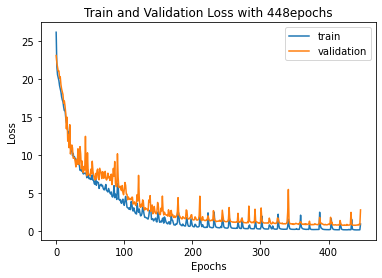

In [30]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [31]:
predict1=np.zeros((4096,))
for i in range((test_size-3)*l2r,(test_size-2)*l2r):
    predict1[(i-(test_size-3)*l2r)*os:(i-(test_size-3)*l2r+1)*os,]=predictions[i]
    
predict2=np.zeros((4096,))
for i in range((test_size-2)*l2r,(test_size-1)*l2r):
    predict2[(i-(test_size-2)*l2r)*os:(i-(test_size-2)*l2r+1)*os,]=predictions[i]
    
predict3=np.zeros((4096,))
for i in range((test_size-1)*l2r,test_size*l2r):
    predict3[(i-(test_size-1)*l2r)*os:(i-(test_size-1)*l2r+1)*os,]=predictions[i]

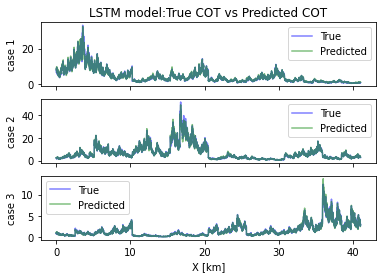

In [35]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/LSTM 32 predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM model:True COT vs Predicted COT")
ax.plot(x[:os*l2r],data[num-3,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict1,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r],data[num-2,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict2,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r],data[num-1,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict3,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

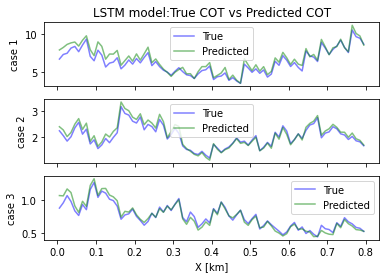

In [36]:
# plotting ----------------------------------------------------------------------------------------------------------------
fgnm = "plots/LSTM 32 predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_COT_values"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM model:True COT vs Predicted COT")
ax.plot(x[:os*l2r][:80],data[num-3,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict1[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r][:80],data[num-2,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict2[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r][:80],data[num-1,:os*l2r,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r][:80],predict3[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')